# Introduction

# Multi-armed bandits

First we define the class bandit using the code provided in [Shangtong Zhang's GitHub](https://github.com/ShangtongZhang/reinforcement-learning-an-introduction):

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from tqdm import trange

class Bandit:
    """
    :param k_arm: number of arms
    :param epsilon: probability for exploration in epsilon-greedy algorithm
    :param initial: initial estimation for each action
    :param step_size: constant step size for updating estimations
    :param sample_averages: if True, use sample averages to update estimations instead of constant step size
    :param UCB_param: if not None, use UCB algorithm to select action
    :param gradient: if True, use gradient based bandit algorithm
    :param gradient_baseline: if True, use average reward as baseline for gradient based bandit algorithm
    """
    def __init__(self, 
                 k_arm = 10, 
                 epsilon = 0.0, 
                 initial = 0.0, 
                 step_size = 0.1, 
                 sample_averages = False, 
                 UCB_param = None,
                 gradient = False, 
                 gradient_baseline = False, 
                 true_reward = 0.0):
        self.k = k_arm
        self.epsilon = epsilon
        self.initial = initial
        self.step_size = step_size
        self.sample_averages = sample_averages
        self.UCB_param = UCB_param
        self.gradient = gradient
        self.gradient_baseline = gradient_baseline
        self.true_reward = true_reward
        
        self.indices = np.arange(self.k)
        self.time = 0
        self.average_reward = 0

    def reset(self):
        """ Reset the counts and the values """
        self.q_true = np.random.randn(self.k) + self.true_reward
        self.q_estimation = np.zeros(self.k) + self.initial
        self.action_count = np.zeros(self.k)
        self.best_action = np.argmax(self.q_true)

    def act(self):
        """ Get the best action """
        # Sample average algorithm
        if np.random.rand() < self.epsilon:
            return np.random.choice(self.indices)
        
        # UCB algorithm
        if self.UCB_param is not None:
            UCB_estimation = self.q_estimation + \
                self.UCB_param * np.sqrt(np.log(self.time + 1) / (self.action_count + 1e-5))
            q_best = np.max(UCB_estimation)
            return np.random.choice([action for action, q in enumerate(UCB_estimation) if q == q_best])
        
        # Gradient based algorithm
        if self.gradient:
            exp_est = np.exp(self.q_estimation)
            self.action_prob = exp_est / np.sum(exp_est)
            return np.random.choice(self.indices, p = self.action_prob)

        q_best = np.max(self.q_estimation)
        return np.random.choice([action for action, q in enumerate(self.q_estimation) if q == q_best])

    def step(self, action):
        """ Take an action and update estimation for this action """
        # generate the reward under N(real reward, 1)
        reward = np.random.randn() + self.q_true[action]
        self.time += 1
        self.action_count[action] += 1
        self.average_reward += (reward - self.average_reward) / self.time

        if self.sample_averages:
            # update estimation using sample averages
            self.q_estimation[action] += (reward - self.q_estimation[action]) / self.action_count[action]
        elif self.gradient:
            # update estimation using gradient based algorithm
            one_hot = np.zeros(self.k)
            one_hot[action] = 1
            if self.gradient_baseline:
                baseline = self.average_reward
            else:
                baseline = 0
            self.q_estimation += self.step_size * (reward - baseline) * (one_hot - self.action_prob)
        else:
            # update estimation with constant step size
            self.q_estimation[action] += self.step_size * (reward - self.q_estimation[action])
        return reward

## Exercise 3

100%|██████████| 1000/1000 [00:17<00:00, 56.36it/s]


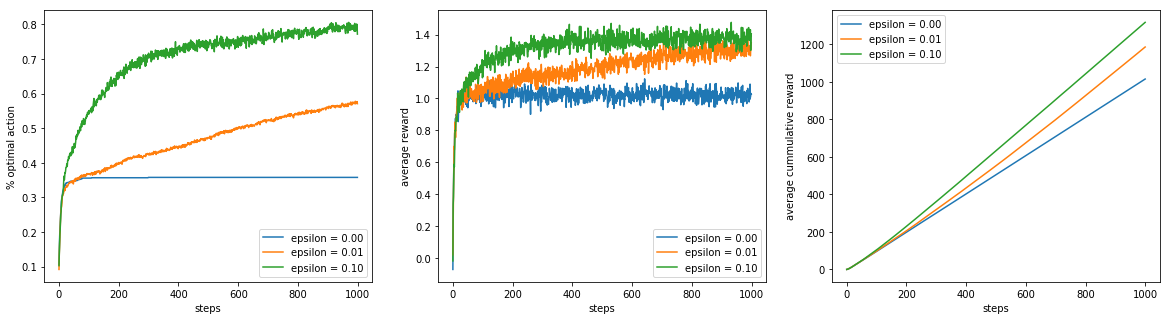

100%|██████████| 1000/1000 [00:35<00:00, 28.14it/s]


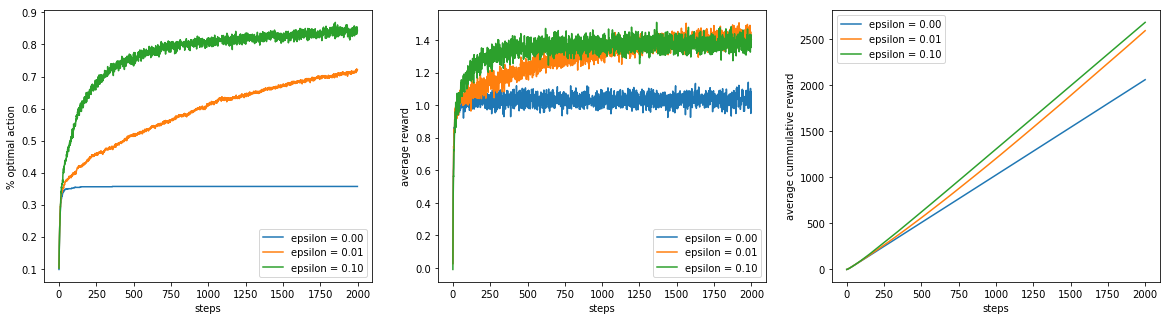

100%|██████████| 1000/1000 [01:27<00:00, 11.48it/s]


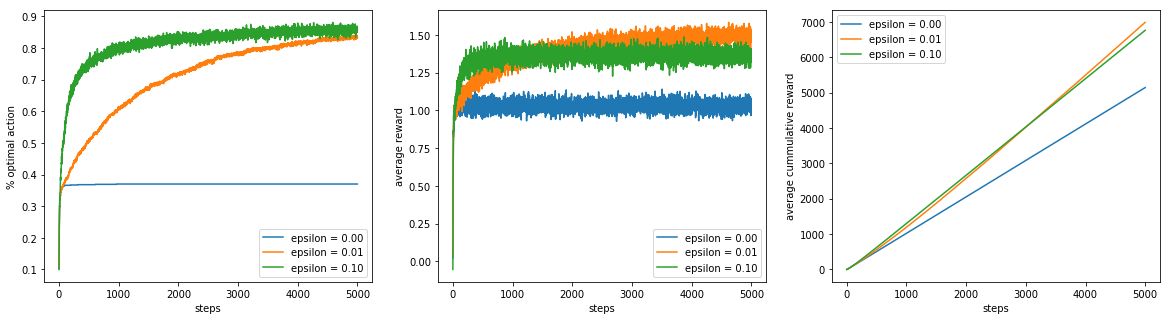

In [5]:
def simulate(runs, time, bandits):
    best_action_counts = np.zeros((len(bandits), runs, time))
    rewards = np.zeros(best_action_counts.shape)
    cum_rewards = np.zeros(best_action_counts.shape)
    for i, bandit in enumerate(bandits):
        for r in trange(runs):
            bandit.reset()
            for t in range(time):
                
                action = bandit.act()
                reward = bandit.step(action)
                rewards[i, r, t] = reward
                if action == bandit.best_action:
                    best_action_counts[i, r, t] = 1
    mean_best_action_counts = best_action_counts.mean(axis=1)
    mean_rewards = rewards.mean(axis=1)
    mean_cum_rewards = np.cumsum(rewards, axis=2).mean(axis=1)
    return mean_best_action_counts, mean_rewards, mean_cum_rewards

def exercise_2_3(runs=2000, time=1000):
    epsilons = [0, 0.01, 0.1]
    bandits = [Bandit(epsilon=eps, sample_averages=True) for eps in epsilons]
    best_action_counts, rewards, cum_rewards = simulate(runs, time, bandits)

    plt.figure(figsize=(20, 5))

    plt.subplot(1, 3, 1)
    for eps, counts in zip(epsilons, best_action_counts):
        plt.plot(counts, label='epsilon = %.02f' % (eps))
    plt.xlabel('steps')
    plt.ylabel('% optimal action')
    plt.legend()
    
    plt.subplot(1, 3, 2)
    for eps, rewards in zip(epsilons, rewards):
        plt.plot(rewards, label='epsilon = %.02f' % (eps))
    plt.xlabel('steps')
    plt.ylabel('average reward')
    plt.legend()

    plt.subplot(1, 3, 3)
    for eps, counts in zip(epsilons, cum_rewards):
        plt.plot(counts, label='epsilon = %.02f' % (eps))
    plt.xlabel('steps')
    plt.ylabel('average cummulative reward')
    plt.legend()
    
    plt.show()

exercise_2_3(runs=1000, time=1000)
exercise_2_3(runs=1000, time=2000)
exercise_2_3(runs=1000, time=5000)
exercise_2_3(runs=1000, time=10000)

## Exercise 5

100%|██████████| 2000/2000 [08:20<00:00,  3.98it/s]


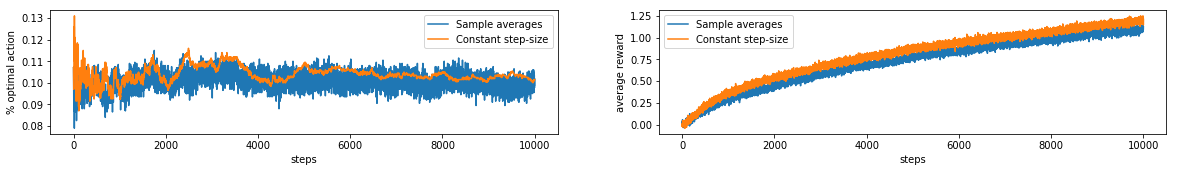

In [11]:
def simulate(runs, time, bandits):
    best_action_counts = np.zeros((len(bandits), runs, time))
    rewards = np.zeros(best_action_counts.shape)
    for i, bandit in enumerate(bandits):
        for r in trange(runs):
            bandit.reset()
            bandit.q_true = np.zeros(bandit.k)
            for t in range(time):
                bandit.q_true += np.random.normal(0, 0.01, bandit.k)
                action = bandit.act()
                reward = bandit.step(action)
                rewards[i, r, t] = reward
                if action == bandit.best_action:
                    best_action_counts[i, r, t] = 1
    mean_best_action_counts = best_action_counts.mean(axis=1)
    mean_rewards = rewards.mean(axis=1)
    return mean_best_action_counts, mean_rewards

def exercise_2_5(runs=2000, time=1000):
    bandits = [Bandit(epsilon=0.1, sample_averages=True),
               Bandit(step_size=0.1, sample_averages=False)
              ]
    labels = ["Sample averages", "Constant step-size"]
    best_action_counts, rewards = simulate(runs, time, bandits)

    plt.figure(figsize=(20, 5))

    plt.subplot(2, 2, 1)
    for label, counts in zip(labels, best_action_counts):
        plt.plot(counts, label=label)
    plt.xlabel('steps')
    plt.ylabel('% optimal action')
    plt.legend()
    
    plt.subplot(2, 2, 2)
    for label, reward in zip(labels, rewards):
        plt.plot(reward, label=label)
    plt.xlabel('steps')
    plt.ylabel('average reward')
    plt.legend()
    
    plt.show()

exercise_2_5(runs=2000, time=10000)